In [1]:
import math
from typing import List, Dict

import cv2
import mlflow
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torchvision.models.detection import _utils as det_utils
from torchvision.models.detection.mask_rcnn import MaskRCNNHeads, MaskRCNNPredictor
from torchvision.models.detection.roi_heads import fastrcnn_loss, maskrcnn_loss, maskrcnn_inference

from src.common.conics import plot_conics, crater_representation, ellipse_axes
from src.detection import create_detection_model
from src.detection.training import get_dataloaders

mlflow.set_tracking_uri("http://localhost:5000/")
mlflow.set_experiment("crater-detection")

In [90]:
dataset_path = "../data/dataset_instanced_edge.h5"
batch_size = 10
num_workers = 4

train_loader, validation_loader, test_loader = get_dataloaders(dataset_path, batch_size, num_workers)

In [91]:
device = torch.device('cpu')
model = create_detection_model()
model.to(device)

checkpoint = mlflow.pytorch.load_state_dict('../artifacts/1/35cf2074edac41659c33b334cc73d2c0/artifacts/checkpoint')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## IDEAS

* Subclass `RoIHeads`
* Replace `mask_roi_pool`, `mask_head`, and `mask_predictor` with custom ellipse fitting FCN
* Combination?

In [92]:
from torchvision.ops import boxes as box_ops, MultiScaleRoIAlign


class RoIHeads(nn.Module):
    def __init__(self,
                 box_roi_pool,
                 box_head,
                 box_predictor,
                 # Faster R-CNN training
                 fg_iou_thresh, bg_iou_thresh,
                 batch_size_per_image, positive_fraction,
                 bbox_reg_weights,
                 # Faster R-CNN inference
                 score_thresh,
                 nms_thresh,
                 detections_per_img,
                 #mask
                 mask_roi_pool=None,
                 mask_head=None,
                 mask_predictor=None
                 ):
        super(RoIHeads, self).__init__()

        self.box_similarity = box_ops.box_iou
        # assign ground-truth boxes for each proposal
        self.proposal_matcher = det_utils.Matcher(
            fg_iou_thresh,
            bg_iou_thresh,
            allow_low_quality_matches=False)

        self.fg_bg_sampler = det_utils.BalancedPositiveNegativeSampler(
            batch_size_per_image,
            positive_fraction)

        if bbox_reg_weights is None:
            bbox_reg_weights = (10., 10., 5., 5.)
        self.box_coder = det_utils.BoxCoder(bbox_reg_weights)

        self.box_roi_pool = box_roi_pool
        self.box_head = box_head
        self.box_predictor = box_predictor

        self.score_thresh = score_thresh
        self.nms_thresh = nms_thresh
        self.detections_per_img = detections_per_img

        self.mask_roi_pool = mask_roi_pool
        self.mask_head = mask_head
        self.mask_predictor = mask_predictor

    def has_mask(self):
        if self.mask_roi_pool is None:
            return False
        if self.mask_head is None:
            return False
        if self.mask_predictor is None:
            return False
        return True

    def assign_targets_to_proposals(self, proposals, gt_boxes, gt_labels):
        matched_idxs = []
        labels = []
        for proposals_in_image, gt_boxes_in_image, gt_labels_in_image in zip(proposals, gt_boxes, gt_labels):

            if gt_boxes_in_image.numel() == 0:
                # Background image
                device = proposals_in_image.device
                clamped_matched_idxs_in_image = torch.zeros(
                    (proposals_in_image.shape[0],), dtype=torch.int64, device=device
                )
                labels_in_image = torch.zeros(
                    (proposals_in_image.shape[0],), dtype=torch.int64, device=device
                )
            else:
                #  set to self.box_similarity when https://github.com/pytorch/pytorch/issues/27495 lands
                match_quality_matrix = box_ops.box_iou(gt_boxes_in_image, proposals_in_image)
                matched_idxs_in_image = self.proposal_matcher(match_quality_matrix)

                clamped_matched_idxs_in_image = matched_idxs_in_image.clamp(min=0)

                labels_in_image = gt_labels_in_image[clamped_matched_idxs_in_image]
                labels_in_image = labels_in_image.to(dtype=torch.int64)

                # Label background (below the low threshold)
                bg_inds = matched_idxs_in_image == self.proposal_matcher.BELOW_LOW_THRESHOLD
                labels_in_image[bg_inds] = 0

                # Label ignore proposals (between low and high thresholds)
                ignore_inds = matched_idxs_in_image == self.proposal_matcher.BETWEEN_THRESHOLDS
                labels_in_image[ignore_inds] = -1  # -1 is ignored by sampler

            matched_idxs.append(clamped_matched_idxs_in_image)
            labels.append(labels_in_image)
        return matched_idxs, labels

    def subsample(self, labels):
        sampled_pos_inds, sampled_neg_inds = self.fg_bg_sampler(labels)
        sampled_inds = []
        for img_idx, (pos_inds_img, neg_inds_img) in enumerate(
                zip(sampled_pos_inds, sampled_neg_inds)
        ):
            img_sampled_inds = torch.where(pos_inds_img | neg_inds_img)[0]
            sampled_inds.append(img_sampled_inds)
        return sampled_inds

    def add_gt_proposals(self, proposals, gt_boxes):
        proposals = [
            torch.cat((proposal, gt_box))
            for proposal, gt_box in zip(proposals, gt_boxes)
        ]

        return proposals

    def check_targets(self, targets):
        assert targets is not None
        assert all(["boxes" in t for t in targets])
        assert all(["labels" in t for t in targets])
        if self.has_mask():
            assert all(["masks" in t for t in targets])

    def select_training_samples(self,
                                proposals,
                                targets
                                ):
        self.check_targets(targets)
        assert targets is not None
        dtype = proposals[0].dtype
        device = proposals[0].device

        gt_boxes = [t["boxes"].to(dtype) for t in targets]
        gt_labels = [t["labels"] for t in targets]

        # append ground-truth bboxes to propos
        proposals = self.add_gt_proposals(proposals, gt_boxes)

        # get matching gt indices for each proposal
        matched_idxs, labels = self.assign_targets_to_proposals(proposals, gt_boxes, gt_labels)
        # sample a fixed proportion of positive-negative proposals
        sampled_inds = self.subsample(labels)
        matched_gt_boxes = []
        num_images = len(proposals)
        for img_id in range(num_images):
            img_sampled_inds = sampled_inds[img_id]
            proposals[img_id] = proposals[img_id][img_sampled_inds]
            labels[img_id] = labels[img_id][img_sampled_inds]
            matched_idxs[img_id] = matched_idxs[img_id][img_sampled_inds]

            gt_boxes_in_image = gt_boxes[img_id]
            if gt_boxes_in_image.numel() == 0:
                gt_boxes_in_image = torch.zeros((1, 4), dtype=dtype, device=device)
            matched_gt_boxes.append(gt_boxes_in_image[matched_idxs[img_id]])

        regression_targets = self.box_coder.encode(matched_gt_boxes, proposals)
        return proposals, matched_idxs, labels, regression_targets

    def postprocess_detections(self,
                               class_logits,
                               box_regression,
                               proposals,
                               image_shapes
                               ):
        device = class_logits.device
        num_classes = class_logits.shape[-1]

        boxes_per_image = [boxes_in_image.shape[0] for boxes_in_image in proposals]
        pred_boxes = self.box_coder.decode(box_regression, proposals)

        pred_scores = torch.softmax(class_logits, -1)

        pred_boxes_list = pred_boxes.split(boxes_per_image, 0)
        pred_scores_list = pred_scores.split(boxes_per_image, 0)

        all_boxes = []
        all_scores = []
        all_labels = []
        for boxes, scores, image_shape in zip(pred_boxes_list, pred_scores_list, image_shapes):
            boxes = box_ops.clip_boxes_to_image(boxes, image_shape)

            # create labels for each prediction
            labels = torch.arange(num_classes, device=device)
            labels = labels.view(1, -1).expand_as(scores)

            # remove predictions with the background label
            boxes = boxes[:, 1:]
            scores = scores[:, 1:]
            labels = labels[:, 1:]

            # batch everything, by making every class prediction be a separate instance
            boxes = boxes.reshape(-1, 4)
            scores = scores.reshape(-1)
            labels = labels.reshape(-1)

            # remove low scoring boxes
            inds = torch.where(scores > self.score_thresh)[0]
            boxes, scores, labels = boxes[inds], scores[inds], labels[inds]

            # remove empty boxes
            keep = box_ops.remove_small_boxes(boxes, min_size=1e-2)
            boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

            # non-maximum suppression, independently done per class
            keep = box_ops.batched_nms(boxes, scores, labels, self.nms_thresh)
            # keep only topk scoring predictions
            keep = keep[:self.detections_per_img]
            boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

            all_boxes.append(boxes)
            all_scores.append(scores)
            all_labels.append(labels)

        return all_boxes, all_scores, all_labels

    def forward(self,
                features,
                proposals,
                image_shapes,
                targets=None
                ):
        """
        Args:
            features (List[Tensor])
            proposals (List[Tensor[N, 4]])
            image_shapes (List[Tuple[H, W]])
            targets (List[Dict])
        """
        if targets is not None:
            for t in targets:
                # TODO: https://github.com/pytorch/pytorch/issues/26731
                floating_point_types = (torch.float, torch.double, torch.half)
                assert t["boxes"].dtype in floating_point_types, 'target boxes must of float type'
                assert t["labels"].dtype == torch.int64, 'target labels must of int64 type'

        if self.training:
            proposals, matched_idxs, labels, regression_targets = self.select_training_samples(proposals, targets)
        else:
            labels = None
            regression_targets = None
            matched_idxs = None

        box_features = self.box_roi_pool(features, proposals, image_shapes)
        box_features = self.box_head(box_features)
        class_logits, box_regression = self.box_predictor(box_features)

        result: List[Dict[str, torch.Tensor]] = []
        losses = {}
        if self.training:
            assert labels is not None and regression_targets is not None
            loss_classifier, loss_box_reg = fastrcnn_loss(
                class_logits, box_regression, labels, regression_targets)
            losses = {
                "loss_classifier": loss_classifier,
                "loss_box_reg": loss_box_reg
            }
        else:
            boxes, scores, labels = self.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
            num_images = len(boxes)
            for i in range(num_images):
                result.append(
                    {
                        "boxes": boxes[i],
                        "labels": labels[i],
                        "scores": scores[i],
                    }
                )

        if self.has_mask():
            mask_proposals = [p["boxes"] for p in result]
            if self.training:
                assert matched_idxs is not None
                # during training, only focus on positive boxes
                num_images = len(proposals)
                mask_proposals = []
                pos_matched_idxs = []
                for img_id in range(num_images):
                    pos = torch.where(labels[img_id] > 0)[0]
                    mask_proposals.append(proposals[img_id][pos])
                    pos_matched_idxs.append(matched_idxs[img_id][pos])
            else:
                pos_matched_idxs = None

            if self.mask_roi_pool is not None:
                mask_features = self.mask_roi_pool(features, mask_proposals, image_shapes)
                mask_features = self.mask_head(mask_features)
                mask_logits = self.mask_predictor(mask_features)
            else:
                raise Exception("Expected mask_roi_pool to be not None")

            loss_mask = {}
            if self.training:
                assert targets is not None
                assert pos_matched_idxs is not None
                assert mask_logits is not None

                gt_masks = [t["masks"] for t in targets]
                gt_labels = [t["labels"] for t in targets]
                rcnn_loss_mask = maskrcnn_loss(
                    mask_logits, mask_proposals,
                    gt_masks, gt_labels, pos_matched_idxs)
                loss_mask = {
                    "loss_mask": rcnn_loss_mask
                }
            else:
                labels = [r["labels"] for r in result]
                masks_probs = maskrcnn_inference(mask_logits, labels)
                for mask_prob, r in zip(masks_probs, result):
                    r["masks"] = mask_prob

            losses.update(loss_mask)


        return result, losses

In [93]:
mask_roi_pool = MultiScaleRoIAlign(
    featmap_names=['0', '1', '2', '3'],
    output_size=14,
    sampling_ratio=2
)

mask_layers = (256, 256, 256, 256)
mask_dilation = 1
mask_head = MaskRCNNHeads(model.backbone.out_channels, mask_layers, mask_dilation)

mask_predictor_in_channels = 256  # == mask_layers[-1]
mask_dim_reduced = 256
mask_predictor = MaskRCNNPredictor(mask_predictor_in_channels,
                                   mask_dim_reduced, 2)

for m in (mask_roi_pool, mask_head, mask_predictor):
    m.to(device)

In [94]:
model.eval()
images, targets = next(iter(test_loader))

with torch.no_grad():
    out = model(images)

In [95]:
test_masks = out[0]['masks']
test_scores = out[0]['scores']
test_masks = test_masks[test_scores > 0.8]

### Baseline

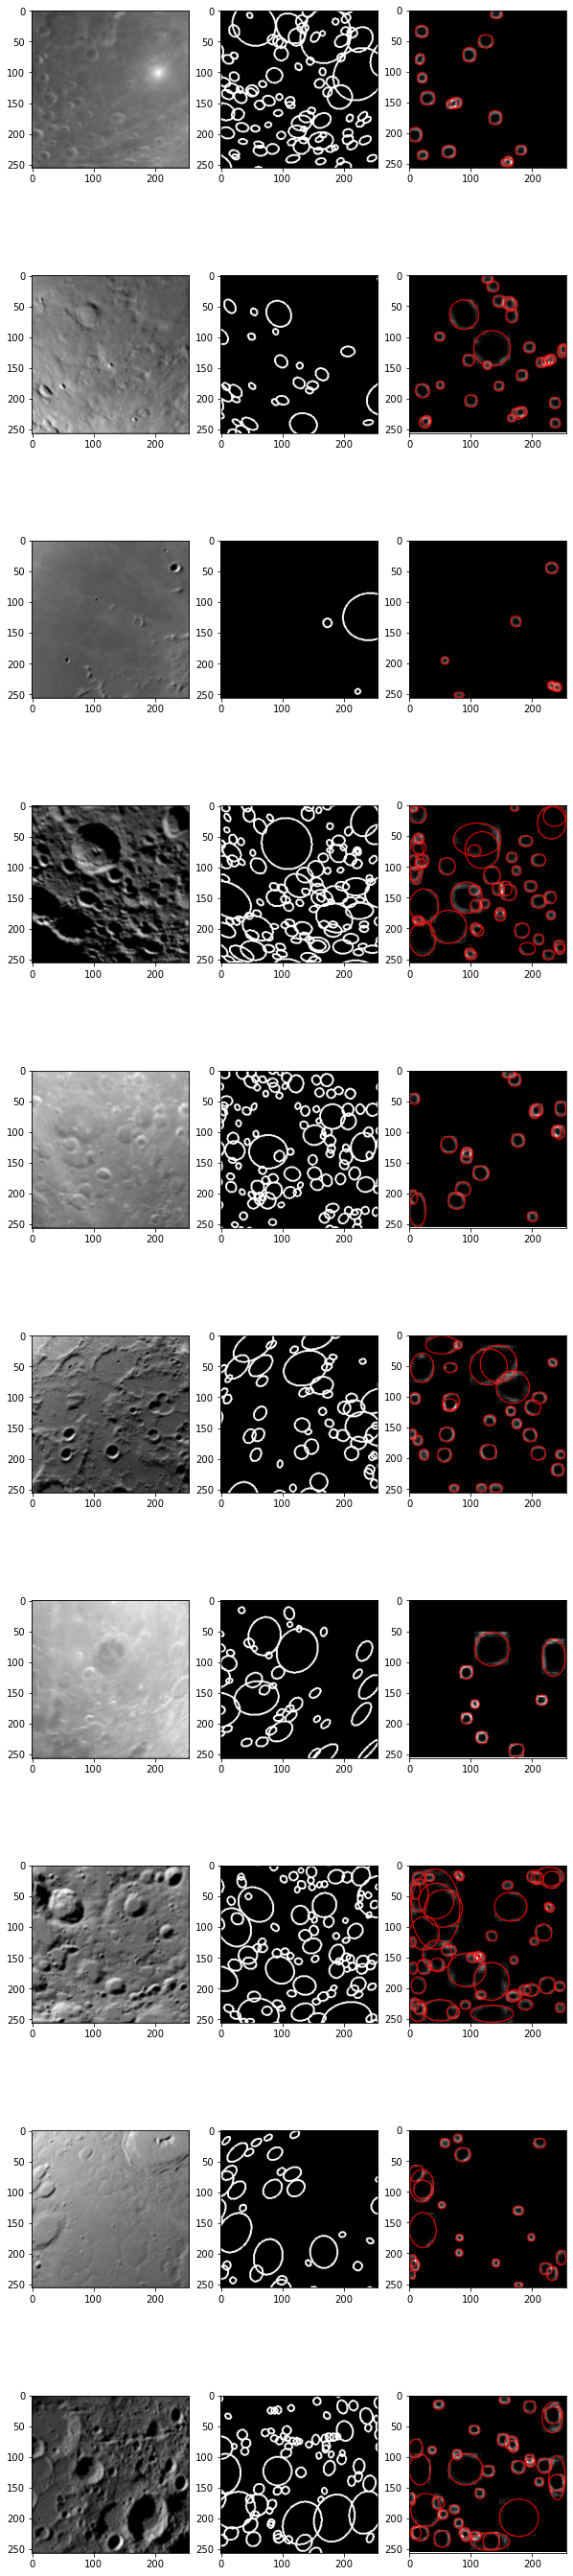

In [101]:
fig, axes = plt.subplots(len(out), 3, figsize=(10, len(out)*5))
for j in range(len(out)):
    test_masks = out[j]['masks']
    target_masks = targets[j]['masks']
    test_scores = out[j]['scores']
    test_masks = test_masks[test_scores > 0.5]
    for i in range(test_masks.shape[0]):
        cnt = np.array(np.where(test_masks[i, 0].numpy() > 0)).T[:, None, :]
        cnt[..., [0, 1]] = cnt[..., [1, 0]]
        (x, y), (a, b), psi = cv2.fitEllipse(cnt)
        psi = np.radians(psi)
        A = crater_representation(a, b, psi, x, y)
        plot_conics(A, ax=axes[j, 2])

    axes[j, 0].imshow(images[j][0].numpy(), cmap='gray')
    axes[j, 1].imshow(np.sum(target_masks.numpy(), axis=0), cmap='gray')
    axes[j, 2].imshow(np.sum(test_masks.numpy(), axis=0)[0], cmap='gray')

In [71]:
class EllipseFitter(nn.Module):
    def __init__(self):
        super(EllipseFitter, self).__init__()

    def __call__(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        D = torch.hstack(
            (x[..., None] ** 2, x[..., None] * y[..., None],
             y[..., None] ** 2, x[..., None], y[..., None],
             torch.ones_like(x[..., None]))
        )
        S = D.T.mm(D).type(torch.float32)
        C = torch.zeros((6, 6))
        C[0, 2], C[2, 0], C[1, 1] = 2, 2, -1
        # U, s, V = torch.linalg.svd(torch.mm(torch.linalg.inv(S), C), compute_uv=True)
        E, V = torch.linalg.eigh(torch.mm(torch.linalg.inv(S), C.T))
        n = E.argmax()
        A = V[:, n]

        b, c, d, f, g, a = A[1] / 2., A[2], A[3] / 2., A[4] / 2., A[5], A[0]

        return torch.tensor([[a, b, d],
                             [b, c, f],
                             [d, f, g]])


In [72]:
ell_fitter = EllipseFitter()
idx, x, y = (arr[..., None] for arr in torch.where(test_masks[:, 0, ...] > 0.25))
rim_pixels = torch.hstack((idx, y, x))
num_ellipses = rim_pixels[:, 0].max() + 1
ellipses = torch.zeros((num_ellipses, 3, 3))
nonzero = torch.ones(num_ellipses, dtype=torch.bool)

for i in range(num_ellipses):
    rp = rim_pixels[rim_pixels[:, 0] == i][:, 1:].T
    if len(rp.T) > 100:
        ellipses[i] = ell_fitter(*rp)
    else:
        nonzero[i] = False

ellipses = ellipses[nonzero]
fig, ax = plt.subplots(figsize=(15, 15))

ax.imshow(np.sum(test_masks.numpy(), axis=0)[0], cmap='gray')
plot_conics(ellipses, ax=ax)
ellipses

AttributeError: module 'torch.linalg' has no attribute 'eig'

In [36]:
x, y = rim_pixels[rim_pixels[:, 0] == 0][:, 1:].T
D = torch.hstack(
    (x[..., None] ** 2, x[..., None] * y[..., None],
     y[..., None] ** 2, x[..., None], y[..., None],
     torch.ones_like(x[..., None]))
)
D.T.mm(D)

tensor([[220992301516, 137673601438,  85985025498,   1164116490,    725774598,
              6137212],
        [137673601438,  85985025498,  53838871624,    725774598,    453637508,
              3829228],
        [ 85985025498,  53838871624,  33796305846,    453637508,    284262516,
              2395278],
        [  1164116490,    725774598,    453637508,      6137212,      3829228,
                32382],
        [   725774598,    453637508,    284262516,      3829228,      2395278,
                20220],
        [     6137212,      3829228,      2395278,        32382,        20220,
                  171]])

In [65]:
np.dot(D.numpy().T, D.numpy())
S = D.T.mm(D).type(torch.float32)
C = torch.zeros((6, 6))
C[0, 2], C[2, 0], C[1, 1] = 2, 2, -1
# U, s, V = torch.linalg.svd(torch.mm(torch.linalg.inv(S), C), compute_uv=True)
E, V = torch.linalg.eigh(torch.linalg.inv(S).mm(C.T))
E

tensor([-2.7082e+00, -5.5990e-03, -1.1503e-05,  1.0224e-06,  5.5615e-03,
         2.7083e+00])

In [113]:
torch.onnx.export(model, torch.ones_like(images[0][None, ...]),
                  "../blobs/CraterRCNN.onnx",
                  input_names=["image"],
                  output_names=["output"],
                  opset_version=11,
                  do_constant_folding=True)

C:\Users\w_dop\miniconda3\envs\crater-detection\lib\site-packages\torch\tensor.py:590: RuntimeWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  'incorrect results).', category=RuntimeWarning)
C:\Users\w_dop\miniconda3\envs\crater-detection\lib\site-packages\torch\nn\functional.py:3522: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  for i in range(dim)
C:\Users\w_dop\miniconda3\envs\crater-detection\lib\site-packages\torchvision\models\detection\anchor_utils.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tenso

In [109]:
torch.ones_like(images[0][None, ...]).shape

torch.Size([1, 1, 256, 256])

In [112]:
import onnx
onnx_model = onnx.load("../blobs/CraterRCNN.onnx")
onnx.checker.check_model(onnx_model, full_check=True)